<a href="https://colab.research.google.com/github/hwanin99/ComputerVision_Seminar/blob/main/Week5_%EC%88%98%EC%97%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


In [ ]:
import torch
device='cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)
device

'cuda'

#1. 데이터 셋 준비하기기

In [ ]:
import torch.nn as nn

#하이퍼 파라미터
batch_size=8
lr=0.0001
epochs=50
optimizer_name='adam'
model_name='resnet_50'
criterion=nn.CrossEntropyLoss().to(device) #cost function

In [ ]:
from dataset import Custom_dataset as C
import os
import glob
import cv2
import time
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

root_path = '/content/drive/MyDrive/CV_seminar_project/'

train_transforms = A.Compose([ #Compose : 여러개를 동시에 적용, Compose자체에도 확률 적용가능능
    A.Resize(224,224),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5), #좌우반전
    A.VerticalFlip(p=0.5), #상하반전
    A.ShiftScaleRotate(p=0.5), 
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5), #색도, 채도, 명도 변경경
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5), #밝기 및 대비를 랜덤 지정
    A.ChannelShuffle(), #RGB채널을 랜덤하게 섞음.
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5), # 약간씩 없애기
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = C(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = C(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = C(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=batch_size, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=batch_size, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=batch_size, shuffle = False, num_workers=0)

#2. 모델 불러오기기

In [ ]:
from torchvision import models #모델 라이브러리 함수

resnet_50=models.resnet50(pretrained=True).to(device) #선행학습 여부

import torch.nn as nn #파이토치 뉴럴네트워크 layer 라이브러리
resnet_50.fc=nn.Linear(resnet_50.fc.in_features,3).to(device)

In [ ]:
from torchsummary import summary #모델 아키텍처 확인하는 함수

summary(resnet_50, input_size=(3,224,224))

In [ ]:
optimizer=torch.optim.Adam(resnet_50.parameters(),lr=lr,weight_decay=1e-8) 

#3. 모델 학습시키기

In [ ]:
train_acc_list = []
train_loss_list = []

test_acc_list = []
test_loss_list = []

for epoch in range(1, epochs) :
  running_loss = 0.0
  test_running_loss=0.0

  total = 0
  correct = 0
  
  train_acc = 0
  test_acc = 0

  resnet_50.train()
  for i, (train_img, train_label) in enumerate(train_loader) :
    # gpu에 할당
    train_img = train_img.to(device)
    train_label = train_label.to(device)
    optimizer.zero_grad(set_to_none = True) # 계산했던 가중치 초기화

    output = resnet_50(train_img) #모델에 입력
    loss = criterion(output, train_label) #loss
    loss.backward() #loss로부터 역전파 : 미분 구하기
    optimizer.step() #학습

    # loss $ acc
    running_loss += loss.item()
    _, predictions = torch.max(output.data, dim=1)
    
    total+=train_label.size(0)
    correct+=(predictions == train_label).sum().item()
    train_acc+=100*(correct/total)
  
  running_loss=round(running_loss/(i+1),3) #소수점 반올림
  print(f'Trainset {epoch}/{epochs} Loss: {running_loss}, Accuracy: {round(train_acc/(i+1),3)}%')  
  train_acc_list.append(train_acc/(i+1))
  train_loss_list.append(running_loss)

  resnet_50.eval()
  for i, (valid_img, valid_label) in enumerate(valid_loader): 
      # gpu에 할당
    valid_img = valid_img.to(device)
    valid_label = valid_label.to(device)
    
    output = resnet_50(valid_img) #모델에 입력
    loss = criterion(output, valid_label) #loss
    
    #loss, acc
    test_running_loss += loss.item()
    _, predictions = torch.max(output.data, dim=1)
    
    total+=valid_label.size(0)
    correct+=(predictions == valid_label).sum().item()
    test_acc+=100*(correct/total)

  test_running_loss=round(test_running_loss/(i+1),3) #소수점 반올림
  print(f'Validset {epoch}/{epochs} Loss: {test_running_loss}, Accuracy: {round(test_acc/(i+1),3)}% \n')  
  test_acc_list.append(test_acc/(i+1))
  test_loss_list.append(test_running_loss)
    

Trainset 1/50 Loss: 0.112, Accuracy: 95.916%
Validset 1/50 Loss: 0.575, Accuracy: 93.983% 

Trainset 2/50 Loss: 0.098, Accuracy: 95.98%
Validset 2/50 Loss: 0.348, Accuracy: 95.361% 

Trainset 3/50 Loss: 0.092, Accuracy: 97.406%
Validset 3/50 Loss: 0.397, Accuracy: 96.358% 

Trainset 4/50 Loss: 0.075, Accuracy: 97.949%
Validset 4/50 Loss: 0.481, Accuracy: 95.544% 

Trainset 5/50 Loss: 0.068, Accuracy: 98.9%
Validset 5/50 Loss: 0.363, Accuracy: 96.218% 

Trainset 6/50 Loss: 0.111, Accuracy: 97.618%
Validset 6/50 Loss: 0.463, Accuracy: 94.631% 

Trainset 7/50 Loss: 0.117, Accuracy: 97.041%
Validset 7/50 Loss: 0.501, Accuracy: 93.845% 

Trainset 8/50 Loss: 0.154, Accuracy: 94.976%
Validset 8/50 Loss: 0.576, Accuracy: 92.32% 

Trainset 9/50 Loss: 0.102, Accuracy: 95.761%
Validset 9/50 Loss: 0.324, Accuracy: 94.879% 

Trainset 10/50 Loss: 0.142, Accuracy: 96.071%
Validset 10/50 Loss: 0.315, Accuracy: 94.47% 

Trainset 11/50 Loss: 0.129, Accuracy: 96.668%
Validset 11/50 Loss: 0.51, Accuracy: 

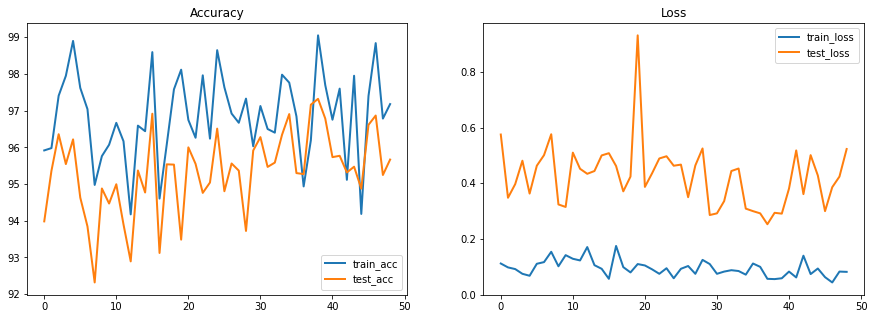

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,5))

axes[0].plot(np.arange(len(train_acc_list)),train_acc_list,label='train_acc',linewidth=2)
axes[0].plot(np.arange(len(test_acc_list)),test_acc_list,label='test_acc',linewidth=2)
axes[0].set_title('Accuracy')
axes[0].legend(loc='best')

axes[1].plot(np.arange(len(train_loss_list)),train_loss_list,label='train_loss',linewidth=2)
axes[1].plot(np.arange(len(test_loss_list)),test_loss_list,label='test_loss',linewidth=2)
axes[1].set_title('Loss')
axes[1].legend(loc='best')
